<a href="https://colab.research.google.com/github/Eduardo-Unicamp/ML/blob/master/Bus_time_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import pandas as pd
from datetime import datetime

In [2]:


def processar_whatsapp_android(caminho_arquivo):
    # Lista para armazenar os dados
    dados = []

    # Regex para o formato Android: "dd/mm/aaaa hh:mm - Nome: Mensagem"
    # Exemplo: 14/01/2024 18:30 - João Silva: O ônibus passou agora
    padrao_regex = re.compile(r'^(\d{1,2}/\d{1,2}/\d{2,4}), (\d{1,2}:\d{2})\s-\s(.*?):\s(.*)$')

    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        # Lê todas as linhas
        linhas = f.readlines()

    buffer_msg = ''
    data_hora = ''
    autor = ''

    for linha in linhas:
        # Tenta casar a linha com o padrão de data/hora
        match = padrao_regex.match(linha)

        if match:
            # Se encontrar uma NOVA mensagem, salva a anterior (se existir)
            if buffer_msg:
                dados.append([data_hora, autor, buffer_msg.strip()])

            # Atualiza para a nova mensagem encontrada
            data_part, hora_part, autor_novo, msg_nova = match.groups()
            data_hora_str = f"{data_part} {hora_part}"

            data_hora = data_hora_str
            autor = autor_novo
            buffer_msg = msg_nova
        else:
            # Se não começar com data, é continuação da mensagem anterior (quebra de linha)
            buffer_msg += ' ' + linha.strip()

    # Não esquecer de salvar a última mensagem do loop
    if buffer_msg:
        dados.append([data_hora, autor, buffer_msg.strip()])

    # Criar DataFrame
    df = pd.DataFrame(dados, columns=['DataHora', 'Autor', 'Mensagem'])

    # Converter a coluna de data para o formato datetime real do Pandas
    df['DataHora'] = pd.to_datetime(df['DataHora'], format='%m/%d/%y %H:%M')

    return df



In [3]:
data = '/content/drive/MyDrive/data_TRIUNFOproject/WhatsApp Chat with Transporte TRIUNFO CMD.txt'

try:
    df_onibus = processar_whatsapp_android(data)

    print(f" Total de mensagens importadas: {len(df_onibus)}")
    print("\n--- Primeiras 5 linhas ---")
    print(df_onibus.head())

except FileNotFoundError:
    print(f"Erro: O arquivo '{data}' não foi encontrado na pasta.")

 Total de mensagens importadas: 30637

--- Primeiras 5 linhas ---
             DataHora             Autor  \
0                 NaT                     
1 2024-01-17 05:37:00  +55 31 8284-8332   
2 2024-01-17 05:46:00  +55 31 7227-1348   
3 2024-01-17 05:48:00  +55 31 8284-8332   
4 2024-01-17 05:48:00  +55 31 8284-8332   

                                            Mensagem  
0  2/17/23, 09:03 - ~ Quenia Batista created grou...  
1  Bom dia grupo  eu queria saber que horas o ôni...  
2           Bom dia ,costuma passar 06 :45 as 06 :55  
3                                                 Ok  
4                                     Muito obrigada  


In [4]:
df_onibus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30637 entries, 0 to 30636
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DataHora  30636 non-null  datetime64[ns]
 1   Autor     30637 non-null  object        
 2   Mensagem  30637 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 718.2+ KB


In [5]:
#Expressões do sistema/indesejadas para serem removidas

termos_sistema = [
    # Entrada/Saída/Membros
    'joined using a group link',
    'was added',
    'added',
    'removed',
    'left',
    'created group',
    'You were added',

    # Mudanças de Perfil/Configuração
    'changed to', # Ex: number changed to...
    'changed their phone number',
    'changed the subject',
    'changed the group description',
    'changed the group icon',
    'security code changed',
    'Messages and calls are end-to-end encrypted',
    'Disappearing messages',

    # Conteúdo removido ou não suportado
    '<Media omitted>',
    'This message was deleted',
    'This message was edited', # Gera duplicata
    'waiting for this message',
    'Missed voice call',
    'Missed video call'
]

# Cria uma expressão Regex única (termo1|termo2|termo3...)
# O 're.escape' não é usado aqui para permitir flexibilidade, mas como são frases fixas, usamos join direto.
# O case=False garante que pegue maiúsculas e minúsculas.
padrao_sistema = '|'.join(termos_sistema)

# APLICA O FILTRO
# Mantém apenas as linhas que NÃO (~) contêm nenhum dos termos
df_onibus = df_onibus[~df_onibus['Mensagem'].str.contains(padrao_sistema, case=False, regex=True)].copy()


In [6]:
df_onibus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27643 entries, 1 to 30636
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DataHora  27643 non-null  datetime64[ns]
 1   Autor     27643 non-null  object        
 2   Mensagem  27643 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 863.8+ KB


In [7]:
df_onibus

,DataHora,Autor,Mensagem
1,2024-01-17 05:37:00,+55 31 8284-8332,Bom dia grupo eu queria saber que horas o ôni...
2,2024-01-17 05:46:00,+55 31 7227-1348,"Bom dia ,costuma passar 06 :45 as 06 :55"
3,2024-01-17 05:48:00,+55 31 8284-8332,Ok
4,2024-01-17 05:48:00,+55 31 8284-8332,Muito obrigada
5,2024-01-17 05:55:00,+55 31 9950-7763,Bom dia o circular já saiu da rodoviária
...,...,...,...
30632,2026-01-14 19:49:00,+55 31 8329-5677,https://youtube.com/shorts/mrZ9y4VjXAA?si=o6mw...
30633,2026-01-14 20:13:00,+55 31 8222-0952,Alguém sabe o de está o ônibus
30634,2026-01-14 20:13:00,+55 31 8222-0952,?
30635,2026-01-14 20:16:00,+55 31 8369-1256,??


In [8]:
#removendo perguntas(contem '?')
df_onibus = df_onibus[~df_onibus['Mensagem'].str.contains('?', regex=False)].copy()

In [9]:
df_onibus

,DataHora,Autor,Mensagem
1,2024-01-17 05:37:00,+55 31 8284-8332,Bom dia grupo eu queria saber que horas o ôni...
2,2024-01-17 05:46:00,+55 31 7227-1348,"Bom dia ,costuma passar 06 :45 as 06 :55"
3,2024-01-17 05:48:00,+55 31 8284-8332,Ok
4,2024-01-17 05:48:00,+55 31 8284-8332,Muito obrigada
5,2024-01-17 05:55:00,+55 31 9950-7763,Bom dia o circular já saiu da rodoviária
...,...,...,...
30627,2026-01-14 19:17:00,+55 31 9988-2661,Cruzeiro
30629,2026-01-14 19:45:00,+55 31 7105-9381,Subindo pra o batata
30630,2026-01-14 19:45:00,+55 31 9902-1099,Córrego Pereira
30631,2026-01-14 19:45:00,+55 31 9561-8979,Obrigada


In [10]:

caminho_drive = '/content/drive/MyDrive/data_TRIUNFOproject/dados_onibus_limpos.csv'

df_onibus.to_csv(caminho_drive, index=False)
print(f"Arquivo salvo no Drive em: {caminho_drive}")

Arquivo salvo no Drive em: /content/drive/MyDrive/data_TRIUNFOproject/dados_onibus_limpos.csv


In [11]:

from collections import Counter
from nltk.corpus import stopwords
import nltk

# Configuração inicial (caso não tenha baixado antes)
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

# Lista de "Gatilhos" - Palavras que ANTECEDEM um local
gatilhos = [
    'no', 'na', 'em', 'do', 'da',
    'pro', 'pra', 'para', 'pelo', 'pela',
    'bairro', 'rua', 'vila', 'alto', 'subindo', 'descendo', 'chegando'
]

def caçar_locais(df):
    candidatos = []

    # Regex para pegar as 2 ou 3 palavras APÓS um gatilho
    # Ex: "no [corrego pereira]" ou "na [rodoviaria]"
    padrao = r'\b(' + '|'.join(gatilhos) + r')\s+([\w\s]+)'

    for msg in df['Mensagem']:
        msg = str(msg).lower()

        # Pula perguntas (pois queremos respostas com locais confirmados)
        if '?' in msg or 'onde' in msg:
            continue

        # Procura os padrões
        matches = re.findall(padrao, msg)

        for gatilho, trecho in matches:
            # Pega as primeiras 3 palavras do trecho encontrado
            palavras = trecho.split()[:3]

            # Limpeza fina: remove palavras muito curtas ou irrelevantes se estiverem sozinhas
            if palavras:
                termo_candidato = " ".join(palavras).strip()
                # Filtra frases muito curtas (ex: "no fim")
                if len(termo_candidato) > 2:
                    candidatos.append(termo_candidato)

    # Conta a frequência de tudo que encontrou
    contagem = Counter(candidatos)

    return contagem

# --- EXECUÇÃO ---
# Supondo que seu DataFrame se chama 'df_onibus' ou 'df' e já foi limpo de mensagens de sistema

ranking_locais = caçar_locais(df_onibus) # Use o nome do seu DF aqui

print("--- TOP  LOCAIS MAIS CITADOS (Candidatos) ---")
# Mostra os 50 termos mais comuns
for local, qtd in ranking_locais.most_common():
    print(f"{qtd} menções: {local}")

--- TOP  LOCAIS MAIS CITADOS (Candidatos) ---
492 menções: rodoviária
145 menções: córrego pereira
125 menções: circular
115 menções: a santa clara
112 menções: batata
97 menções: vila
91 menções: a vila
88 menções: cruzeiro
82 menções: bandeirinha
77 menções: matozinhos
71 menções: bradesco
66 menções: caetano
62 menções: circular por favor
61 menções: vila caetano
60 menções: rodoviária agora
59 menções: santa clara
58 menções: senai
57 menções: matosinhos
55 menções: bougaville
53 menções: são francisco
49 menções: na rodoviária
44 menções: vila são francisco
44 menções: aeroporto
42 menções: a vila caetano
42 menções: vermelho
42 menções: córrego pereira agora
42 menções: ponte lava pé
41 menções: lotérica
39 menções: policlínica
39 menções: mercado
37 menções: a rua do
36 menções: ônibus
36 menções: garagem
35 menções: luiz maria
34 menções: no batata
31 menções: rosário
29 menções: aabb
28 menções: são judas
27 menções: corrego pereira
24 menções: matozinho
23 menções: bela vista

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# Mapeamento Dos Locais (Baseado no Dataset Completo) --> Feito com uso de LLMs
# A ORDEM É CRUCIAL: Termos compostos e específicos primeiro!(assim Vila sao francisco nao é interpretado como Vila(Q se refere À vila caetano))

locais_map = {
    # --- ZONA 1: Nomes Compostos e Específicos (Prioridade Máxima) ---
    'Vila Sao Francisco': [
        'vila sao francisco', 'vila são francisco', 'sao francisco', 'são francisco',
        's fran', 's. francisco'
    ],
    'Corrego Pereira': [
        'corrego pereira', 'córrego pereira', 'corrego', 'córrego',
        'corego', 'corgo'
    ],
    'Bairro Vermelho': [
        'bairro vermelho', 'barro vermelho', 'vermelho'
    ],
    'Ponte da Bandeirinha': [
        'ponte da bandeirinha', 'ponte da band', 'ponte'
    ],
    'Viacao Serro': [
        'viacao serro', 'viação serro', 'garagem', 'serro',
        'frente a garagem', 'porta da garagem'
    ],
    'Supermercado Ki Preço': [
        'ki preço', 'ki preco', 'kipreço', 'ki-preço'
    ],
    'Bela Vista': [
        'bela vista', 'belavista'
    ],
    'Santa Clara': [
        'santa clara', 'st clara'
    ],
    'Sao Judas': [
        'sao judas', 'são judas', 'judas'
    ],
    'Vila Caetano': [
        'vila caetano', 'caetano', 'vila', 'subindo a vila', 'descendo a vila'
    ],
    'Central 25': [
        'central 25', 'central'
    ],
    'Posto de Saude': [
        'posto de saude', 'posto de saúde', 'posto'
    ],

    # --- ZONA 2: Pontos de Referência e Apelidos (Verificar depois) ---
    'Bougainville': [
        'bougainville', 'buganville', 'boungaville', 'bonganvile',
        'bougavilli', 'bugavile', 'bogaville', 'bugaville'
    ],
    'Rodoviaria': [
        'rodoviaria', 'rodoviária', 'rodo', 'rod'
    ],
    'Bandeirinha': [
        'bandeirinha', 'band', 'band arena'
    ],
    'Mercado Municipal': [
        'mercado', 'mercado municipal', 'comercio', 'comércio',
        'mark center', 'centro'
    ],
    'Matosinhos': [
        'matosinhos', 'matuzinhos', 'matozinhos', 'matozinho'
    ],
    'Aeroporto': [
        'aeroporto', 'rua do aeroporto'
    ],
    'Loterica': [
        'loterica', 'lotérica', 'loterica'
    ],
    'AABB': [
        'aabb', 'clube aabb'
    ],
    'Rosario': [
        'rosario', 'rosário'
    ],
    'Policlinica': [
        'policlinica', 'policlínica'
    ],
    'Senai': [
        'senai', 'sennai'
    ],
    'Batata': [
        'batata', 'indo pro batata'
    ],
    'Almoxarifado': [
        'almoxarifado'
    ],
    'Zirigidum': [
        'zirigidum'
    ],
    'Cras': [
        'cras'
    ],
    'Cruzeiro': [
        'cruzeiro'
    ],
    'Cemiterio': [
        'cemiterio', 'cemitério'
    ],
    'Luiz Maria': [
        'luiz maria', 'luis maria'
    ],
    'Integra': [
        'integra', 'íntegra'
    ]
}

In [13]:


def extrair_local_final(texto):
    texto = str(texto).lower()
    # Ignora perguntas
    if 'cade' in texto or 'onde' in texto or 'alguem' in texto: return None

    # Busca no dicionário
    for local_chave, apelidos in locais_map.items():
        for apelido in apelidos:
            if apelido in texto:
                return local_chave
    return None

# Aplica
df_onibus['Local_Identificado'] = df_onibus['Mensagem'].apply(extrair_local_final)

# Limpa os não identificados
df_final = df_onibus.dropna(subset=['Local_Identificado']).copy()

# Mostra a contagem (ranking dos bairros mais falados)
print(df_final['Local_Identificado'].value_counts())

Local_Identificado
Rodoviaria               1144
Vila Caetano              610
Corrego Pereira           577
Matosinhos                412
Bandeirinha               347
Santa Clara               335
Batata                    287
Cruzeiro                  241
Mercado Municipal         238
Ponte da Bandeirinha      182
Loterica                  150
Senai                     148
Rosario                   137
Cemiterio                 137
Policlinica               134
Bougainville              133
Bairro Vermelho           131
Sao Judas                 128
Viacao Serro              127
Vila Sao Francisco        119
Aeroporto                 109
AABB                       98
Bela Vista                 95
Luiz Maria                 82
Posto de Saude             33
Almoxarifado               24
Central 25                 18
Cras                       10
Integra                     7
Supermercado Ki Preço       7
Zirigidum                   1
Name: count, dtype: int64


In [14]:
#quantidade de pontos de referencia identificados (pro caso de nao ter algum em algum df futuro)
qtdd = df_final['Local_Identificado'].value_counts().count()

print(f'{qtdd} locais encontrados')

31 locais encontrados


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. FILTRAGEM DE RUÍDO
# Vamos manter apenas locais que apareceram pelo menos 50 vezes.
# Isso remove erros de digitação raros e locais irrelevantes.
minimo_aparicoes = 20
contagem = df_final['Local_Identificado'].value_counts()
locais_validos = contagem[contagem >= minimo_aparicoes].index

# Cria o Dataset Definitivo para ML (Machine Learning)
df_ml = df_final[df_final['Local_Identificado'].isin(locais_validos)].copy()

print(f"Dataset reduzido de {len(df_final)} para {len(df_ml)} registros (Locais sólidos).")

# 2. ENGENHARIA DE FEATURES (Transformando Hora em Número)
# Exemplo: 01:00 da manhã vira 60 (minutos). 13:30 vira 810 (minutos).
df_ml['Hora'] = df_ml['DataHora'].dt.hour
df_ml['Minuto'] = df_ml['DataHora'].dt.minute
df_ml['Minutos_Absolutos'] = (df_ml['Hora'] * 60) + df_ml['Minuto']
df_ml['Dia_Semana'] = df_ml['DataHora'].dt.dayofweek # 0=Segunda, 6=Domingo



Dataset reduzido de 6201 para 6158 registros (Locais sólidos).


/tmp/ipython-input-3486881196.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_ml, x='Minutos_Absolutos', y='Local_Identificado',


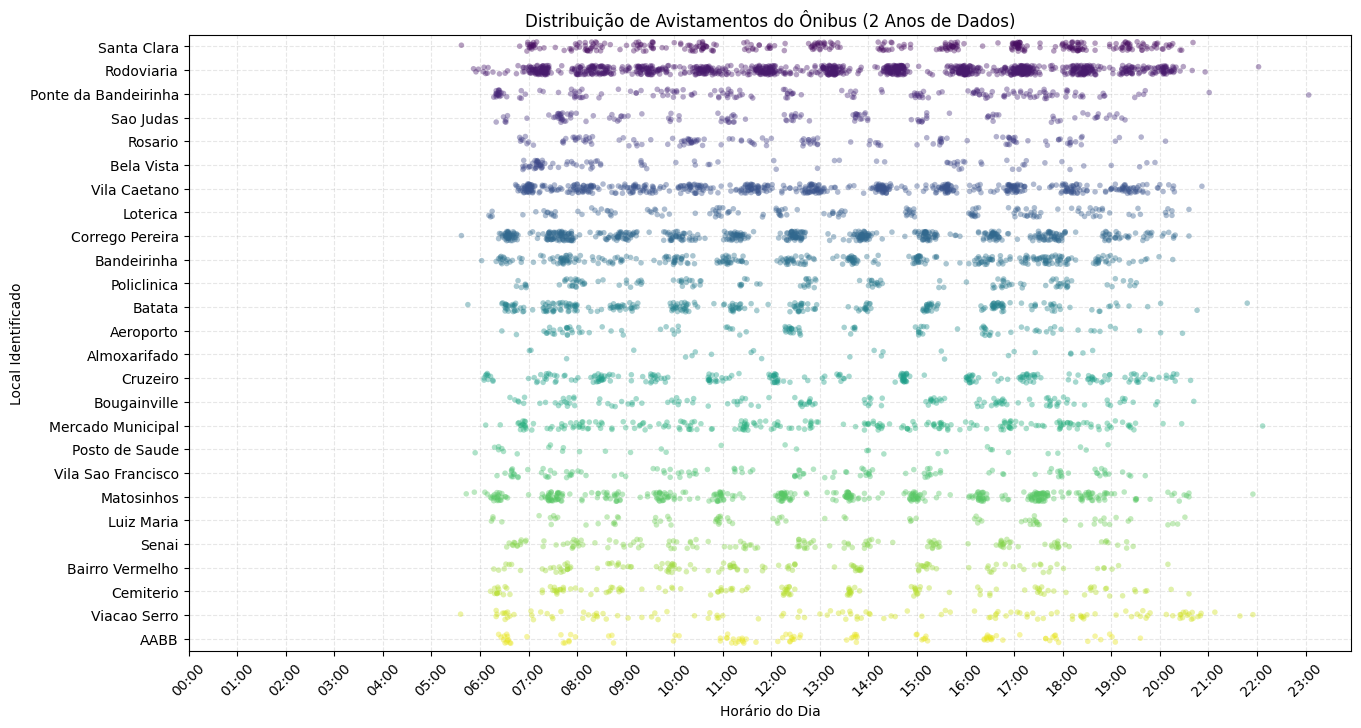

In [16]:
# 3. VISUALIZAÇÃO (O "Raio-X" da Rota)
plt.figure(figsize=(15, 8))

# Vamos plotar: Eixo X = Horário do dia, Eixo Y = Locais
# O 'hue' (cor) ajuda a ver a densidade
sns.stripplot(data=df_ml, x='Minutos_Absolutos', y='Local_Identificado',
              jitter=0.2, alpha=0.4, size=4, palette='viridis')

# Melhorando o eixo X para mostrar horas legíveis (06:00, 08:00...) em vez de minutos (360, 480...)
ticks_loc = range(0, 1440, 60) # De 0 a 24h, a cada 60min
ticks_labels = [f"{h:02d}:00" for h in range(24)]
plt.xticks(ticks_loc, ticks_labels, rotation=45)

plt.title('Distribuição de Avistamentos do Ônibus (2 Anos de Dados)')
plt.xlabel('Horário do Dia')
plt.ylabel('Local Identificado')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

In [17]:
!pip install gpxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00


In [18]:
import gpxpy

In [ ]:
gpx_file = ""